# Metrics III - PS 2
## Marius 

In [ ]:
# import packages 
using LinearAlgebra, Plots, LaTeXStrings, Random, NLSolversBase, DataFrames, CSV, ShiftedArrays, Optim
using Distributions, Statistics

## Question 1

In [ ]:
# import data
dfred = CSV.read("C:\\Users\\mariu\\Downloads\\UNRATE.csv", DataFrame);

# Generate lagged var and store them in matrix
col_name = [:lag1,:lag2,:lag3,:lag4,:lag5,:lag6,:lag7,:lag8,:lag9,:lag10,:lag11,:lag12,:lag13,:lag14,:lag15,:lag16,:lag17]
for (i,col) in zip(1:24,col_name)
    s = lag(dfred[!,2], i)
    dfred[:,col] = s
end

In [ ]:
plot(dfred[:,1], dfred[:,2], label = "Monthly unemployment rate", legend=:topleft, title = "Unemployment data from 1946 to Dec 2021", xlabel="Months since Jan 1946", ylabel="Unemployment rate in %")

In the previous PS, the steep decay of the PACF indicated a one-lag process. Therefore, I implement an AR(1) process. I include the entire time series available at the FRED. <br>

## Maximum Likelihood Estimator
Start by constructing a conditional log-likelihood function. (Define as -Log-Likelihood, as I will employ a minimizer)
$$
\begin{align}
\log\mathcal{L} = -\frac{T-1}{2}\log(2\pi) - \frac{T-1}{2}\log(\sigma^2) - \sum_{t=p+1}^T\Big(\frac{(Y_t - X_t\phi)^2)}{2\sigma^2}\Big)
\end{align}
$$
where $X$ is a matrix of size $T-(p+1) \times (p+1)$ with p being the number of lags included in the model. $Y_t$ is vector of size $T-(p+1)$.

In [ ]:
function Log_Likelihood(X, Y, phi, log_sigma)
    sigma = exp(log_sigma)
    llike = -(length(Y)-1)/2*log(2*pi) - (length(Y)-1)/2*log(sigma^2) - sum(((Y .- X*phi).^2)./(2*sigma^2))
    llike = -llike # since optimizier is a minimizer, transform the problem into a minimization problem
end

Given the likelihood defined above, the strategy looks as follows
<ol>
    <li> Set up empty space for value storage </li>
    <li> For any given number of lags drop rows with missing values </li>
    <li> Perform grid search with initial guess of zero </li>
    <li> Calculate inverse of the Hessian </li>
    <li> Calculate AIC and BIC </li>
</ol>

In [ ]:
# 1. set up empty storage space
parameters_matrix = []
variances = []
log_likelihood_vals = []
fisher = []
est_sigm = []
AIC = []
BIC = []

# Range of number of lags considered
nlags = 1:15

# Perform procedure for any number of lags from 1 to 14 (AR(1) -> AR(15))
for nlag in nlags
    
    d_temp = dropmissing(dfred[!,2:2+nlag]) # reduce dataframe dynamically by number of lags included
    y = d_temp[!,1] # select y
    x = ones(length(d_temp[!,1])) # a constant with ones
    # include lags in the matrix
    for col in 1:nlag
        x_temp = d_temp[!,1+col]
        x = hcat(x, x_temp)
    end
    nvars = nlag + 1 # plus constant
    # Check if twice differentiable at the desired points
    func = TwiceDifferentiable(vars -> Log_Likelihood(x, y, vars[1:nvars], vars[nvars + 1]),
                           zeros(nvars+1); autodiff=:forward)
    # Perform optimization algorithm (here: Newton-Raphson)
    opt = optimize(func, zeros(nvars+1))
    
    parameters = Optim.minimizer(opt) # extract parameters
    parameters[nvars+1] = exp(parameters[nvars+1])
    
    # Create Fisher Matrix as inv
    numerical_hessian = hessian!(func,parameters)
    var_cov_matrix = inv(numerical_hessian)
    
    # Fill the respective storage spaces with estimated values
    append!(log_likelihood_vals, -Optim.minimum(opt))
    append!(parameters_matrix, [parameters[1:nvars]])
    append!(variances, [diag(var_cov_matrix)])
    append!(est_sigm, parameters[end])
    append!(fisher, var_cov_matrix)
    
    # Calculate AIC and BIC
    append!(AIC, 2*(nvars+1) - 2*-Optim.minimum(opt))
    append!(BIC, log(length(d_temp[:,2]))*(nvars+1) - 2*(-Optim.minimum(opt)))
    
end

In [6]:
param_int = parameters_matrix[1][2]
cons = parameters_matrix[1][1]
var_int = variances[1][2]
est_si = est_sigm[1]

println("The coefficient, phi_1, of the lagged dependent variable is $param_int.
    \n The constant is $cons.
\n The associated variance is $var_int.
\n On a related note, the estimated sigma of the model is $est_si")

The coefficient, phi_1, of the lagged dependent variable is 0.9687210814591507.
    
 The constant is 0.18082477541951905.

 The associated variance is 0.0009046904907047247.

 On a related note, the estimated sigma of the model is 0.41828050198361433


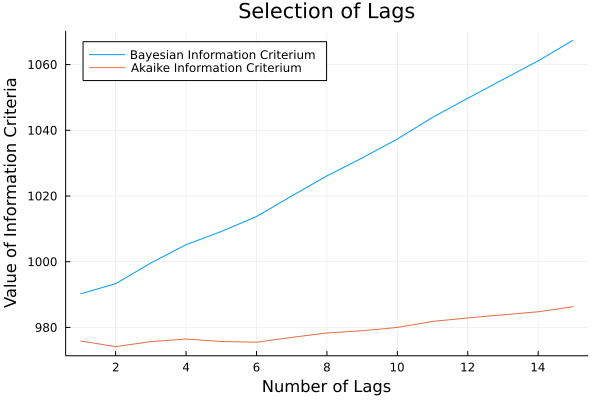

In [7]:
# Plot AIC and BIC
plot(nlags, BIC, label="Bayesian Information Criterium", legend=:topleft, title="Selection of Lags", 
    xlabel="Number of Lags", ylabel="Value of Information Criteria")
plot!(AIC, label="Akaike Information Criterium")

Since the BIC is at it's lowest with just one lag and the AIC seems to be somewhat constant around 1 to 6 lags. It appears that the best choice of lag-length is 1.

### Alternative way to estimate an AR(1) with OLS

Since the grid search might be marginally inaccurate, I implement an OLS for the $AR(1)$.

In [8]:
# Implement an OLS estimation
matrix_1 = inv([length(dfred[!,2])-1 sum(dfred[2:end,3]);sum(dfred[2:end,3]) sum(dfred[2:end,3].^2)])
matrix_2 = [sum(dfred[2:end,2]); sum(dfred[2:end,3].*dfred[2:end,2])]
coef_ = matrix_1*matrix_2
std_ = sum((dfred[2:end,2] .- coef_[1] .- coef_[2].*dfred[2:end,3]).^2)./(length(dfred[!,2])-1);

In [9]:
coef_, std_

([0.18082477541953904, 0.9687210814591498], 0.17476133078798498)

We can see clearly that the coefficients are the same. The estimated variance of the model $\hat{\sigma}$ are slightly different from now $0.17$ compared to $0.42$. This is likely due to imprecision of the grid used to optimize on. For the sake of the exercise, I continue to use my grid-searched variance.

---

To show how the log-likelihood function evolves by some minor deviation, I create a new function that can be iterated over by the variance and not the std. deviation. (The previous used the Standard Deviation as input)

In [10]:
function Log_Likelihood_2(X, Y, phi, sigma)
    llike = -(length(Y)-1)/2*log(2*pi) - (length(Y)-1)/2*log(sigma) - sum(((Y .- X*phi).^2)./(2*sigma))
    llike = -llike
    return llike
end

Log_Likelihood_2 (generic function with 1 method)

Now, I will create a grid and loop over this grid. For every instance, I will estimate the $\hat{\sigma}$ using the already estimated parameters for an $AR(1)$.

In [11]:
# create grid
var_grid = LinRange(0.2*est_sigm[1], 1.1*est_sigm[1], 200)
d_temp_2 = dropmissing(dfred[!,2:2+1]) #drop rows with missing information
x_2 = [ones(length(d_temp_2[!,2])) d_temp_2[:,2] ] # generate input
y_2 = d_temp_2[:,1] # to predict

# loop through variance grid 
var_store = []
for var in var_grid
    var_temp = Log_Likelihood_2(x_2, y_2, parameters_matrix[1], var)
    push!(var_store, -var_temp)
end

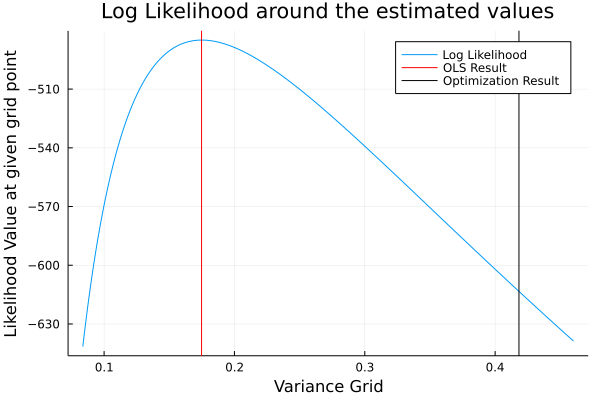

In [12]:
plot(var_grid, var_store, label="Log Likelihood", title="Log Likelihood around the estimated values",
xlabel = "Variance Grid", ylabel="Likelihood Value at given grid point")
vline!([std_ est_sigm[1]], label=["OLS Result" "Optimization Result"], color=[:red :black])

This graph highlights well, how the estimated variance by OLS is more accurate than the one obtained by optimization.

---

The impulse response function of an AR(1) is straight-forward.
<ol>
    <li> We know that the error terms impact any <i>y</i> with coefficient $1$ in the contemporaneous period (as no coef in DGP). Fruther, it does not enter via lagged dependent variables.</li>
    <li> The first lag of the IRF - $\frac{\partial y_{t+1}}{\partial\epsilon_{t}}$ - is the coefficient of the lag.
       <li> For any higher order part of the IRF, we need backwards induction. This means we "discount" the effect with one more coefficient. $ \frac{\partial y_{t+j}}{\partial\epsilon_{t}} = \phi_1 \frac{\partial y_{t+j-1}}{\partial\epsilon_{t}} \: \forall j > 2$ </li>
</ol>
        

In [53]:
# Initiate around 1
irf = ones(100)
irf[2] = parameters_matrix[1][2] # parameter as first lag IRF
# Create higher order lags
for t in 3:100
    irf[t] = parameters_matrix[1][2]*irf[t-1]
end

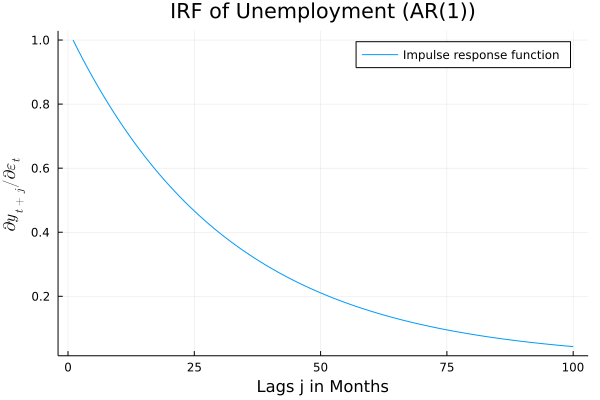

In [54]:
plot(1:100,irf, label="Impulse response function", title="IRF of Unemployment (AR(1))", xlabel="Lags j in Months", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}")

We can see a quite persistent curve which is not surprising given the estimate of close to 1.

## Question 2

### a)
Is the process covariance stationary? <br>
It is stationary if the eigenvalues are inside the unit circle.

In [55]:
# Define Matrix
coef_matrix = [0.5 0.3;0.1 0.8]
eigvals(coef_matrix)

2-element Vector{Float64}:
 0.420871215252208
 0.879128784747792

Since the eigenvalues are smaller than 1 but positive, the process is autocovariance-stationary <br>

### b)
Impulse response functions <br>
As before, we take the derivatives

In [56]:
irf_matrix_1 = [ones(500) zeros(500)] # x row 1; y row 2
irf_matrix_1[2,1] = 0.5; irf_matrix_1[2,2] = 0.1; 
irf_matrix_2 = [zeros(500) ones(500)] # x row 1; y row 2
irf_matrix_2[2,1] = 0.8; irf_matrix_2[2,2] = 0.3;

for t in 2:500
    irf_matrix_1[t,1:2] = coef_matrix*irf_matrix_1[t-1,1:2]
    irf_matrix_2[t,1:2] = coef_matrix*irf_matrix_2[t-1,1:2]
end

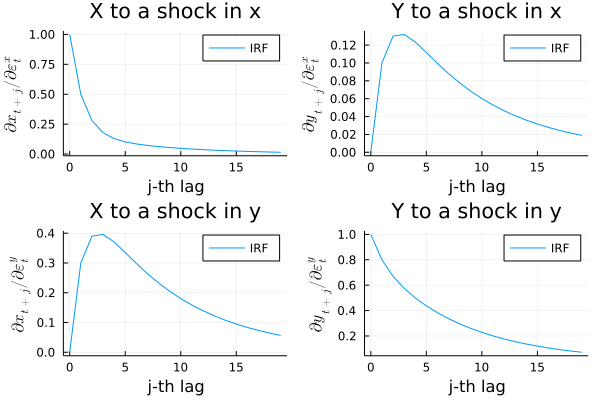

In [57]:
xaxis = 0:499;
p1 = plot(xaxis[1:20], irf_matrix_1[1:20,1], title = "X to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^x")
p2 = plot(xaxis[1:20], irf_matrix_1[1:20,2], title = "Y to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^x")
p3 = plot(xaxis[1:20], irf_matrix_2[1:20,1], title = "X to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^y")
p4 = plot(xaxis[1:20], irf_matrix_2[1:20,2], title = "Y to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^y")

l = @layout [a b; c d]
plot(p1, p2, p3, p4, layout = l)

Now, we're going to simulate the data. Most importantly, the errors are drawn from a multivariate normal distribution.

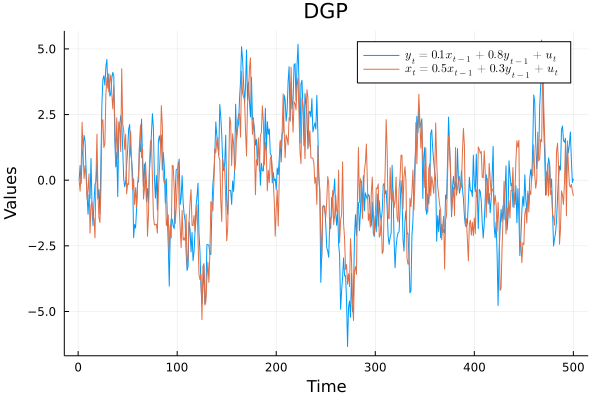

In [58]:
Random.seed!(1234) # set seed
T = 1:500
y = zeros(500); x = zeros(500); # place holder
omega = [1 0.3; 0.3 1]
var = MvNormal([0,0], omega)
error = rand(var, 500)

for t in T[2:500]
    x[t] = 0.5x[t-1] + 0.3y[t-1] + error[1,t]
    y[t] = 0.1x[t-1] + 0.8y[t-1] + error[2,t]
end
plot(T, y, title = "DGP", label = L"y_t = 0.1x_{t-1} + 0.8y_{t-1} + u_t", lw = 1, xlabel="Time")
plot!(T, x, label = L"x_t = 0.5x_{t-1} + 0.3y_{t-1} + u_t", lw = 1, ylabel="Values")

In [59]:
# Creating the lags and store everything in a matrix
data_matrix = [x y ShiftedArray(x, 1) ShiftedArray(y, 1)]
data_matrix[1,3] = 0
data_matrix[1,4] = 0
data_matrix = data_matrix[1:end,:]
data_matrix;

In [104]:
est_coef = (data_matrix[:,1:2]'*data_matrix[:,3:4]) * inv(data_matrix[:,3:4]'*data_matrix[:,3:4])
est_err = data_matrix[:,1:2]' - est_coef*data_matrix[:,3:4]'
var_cov = (1/(500-4)).*(est_err*est_err')
est_coef

2×2 Matrix{Union{Missing, Float64}}:
 0.564401   0.275785
 0.0934687  0.816426

In [105]:
var_cov

2×2 Matrix{Float64}:
 1.05911   0.277273
 0.277273  0.968405

The coefficients resemble the theoretical parameters quite closely. Further, the variance-covariance matrix seems plausible as it is symmetric and variances are close to $1$. <br>

<table style="width:40%">
<tr>
<th>Effect</th>
<th>Theoretical </th>
<th>Estimated</th>
</tr>

<tr>
<th> X -> X</th>
<td>0.5</td>
<td>0.564401</td>
</tr>

<tr>
<th> Y -> X</th>
<td>0.3</td>
<td>0.275785</td>
</tr>
    
<tr>
<th> X -> Y</th>
<td>0.1</td>
<td>0.0934687</td>
</tr>    
    
<tr>
<th> Y -> Y</th>
<td>0.8</td>
<td>0.816426</td>
</tr> 
</table>



### e) 
Does x granger cause y? Does y granger cause x? <br>
We can perform an F-test. To do so run the following procedure
<ol>
    <li> Regress unrestricted model (both variables) and form estimated error terms. (Already done) </li>
    <li> Regress restricted model (only one variable) and form estimated error terms. </li>
    <li> Form sum of squared errors for each error </li>
    <li> Calculate F-statistic </li>
</ol>

In [62]:
# Reduced regression for x on y
est_coef_red_x = (data_matrix[:,1]'*data_matrix[:,3])*inv(data_matrix[:,3]'*data_matrix[:,3])
est_coef_x = (data_matrix[:,1]'*data_matrix[:,3:4])*inv(data_matrix[:,3:4]'*data_matrix[:,3:4])
est_coef_red_y = (data_matrix[:,2]'*data_matrix[:,4])*inv(data_matrix[:,4]'*data_matrix[:,4])
est_coef_y = (data_matrix[:,2]'*data_matrix[:,3:4])*inv(data_matrix[:,3:4]'*data_matrix[:,3:4])
est_coef_red_x, est_coef_x, est_coef_red_y, est_coef_y;

In [63]:
err_red_x = data_matrix[:,1]' - est_coef_red_x*data_matrix[:,3]'
err_x = data_matrix[:,1]' - est_coef_x*data_matrix[:,3:4]'
err_red_y = data_matrix[:,2]' - est_coef_red_y*data_matrix[:,4]'
err_y = data_matrix[:,2]' - est_coef_y*data_matrix[:,3:4]'

sum_err_red_x = sum(err_red_x.^2)
sum_err_red_y = sum(err_red_y.^2)
sum_err_x = sum(err_x.^2)
sum_err_y = sum(err_y.^2);

The coefficients of the reduced form estimates are now quite astray from the theoretical parameters assigned in the data generating process. For instance the coefficient for any IRF of $x_{t-1}$ on $x_t$ is now $0.79$ instead of $0.5$. This is already a strong indicator that we would reject the null of no granger causal effect of $y_{t-1}$ on $x_t$. A similar, even though less strong, reason holds for $x_{t-1}$ on $y_t$. However, $0.876$ does not seem to be unreasonably far away. A more formal test can help.

In [64]:
est_coef_red_x, est_coef_red_y

(0.7947712510517282, 0.876731864305515)

In [65]:
S_x = (sum_err_red_x-sum_err_x)/(sum_err_x/(500-2-1))
S_y = (sum_err_red_y-sum_err_y)/(sum_err_y/(500-2-1))
S_x, S_y

(69.82059053278319, 6.774823610553007)

As the critical value of a $Chi^2(2)$ distribution at the $0.05$ level of significance is $3.84$ and both values are considerably above this value, we reject the null of no Granger causality. Therefore, we can conclude that  <i>x granger causes y </i> and <i> y granger causes x </i>. <br>

---
Now, following the idea from earlier, I compute impulse response functions

In [66]:
q2_irf_matrix_1 = [ones(500) zeros(500)]
q2_irf_matrix_2 = [zeros(500) ones(500)]

for t in 2:500
    q2_irf_matrix_1[t,1:2] = est_coef*q2_irf_matrix_1[t-1,1:2]
    q2_irf_matrix_2[t,1:2] = est_coef*q2_irf_matrix_2[t-1,1:2]
end

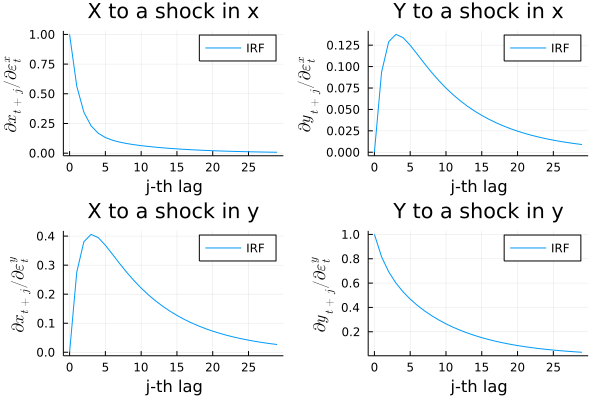

In [67]:
xaxis = 0:499;
q2p1 = plot(xaxis[1:30], q2_irf_matrix_1[1:30,1], title = "X to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^x")
q2p2 = plot(xaxis[1:30], q2_irf_matrix_1[1:30,2], title = "Y to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^x")
q2p3 = plot(xaxis[1:30], q2_irf_matrix_2[1:30,1], title = "X to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^y")
q2p4 = plot(xaxis[1:30], q2_irf_matrix_2[1:30,2], title = "Y to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^y")

plot(q2p1, q2p2, q2p3, q2p4, layout = l)

The last step is to create error bands for the IRF. This is commonly done by bootstrapping. The idea is the following.
<ol>
    <li> Draw from the a random sample from the estimated error terms </li>
    <li> Given these error terms and the parameters from earlier, create new data (series of y's and x's) </li>
    <li> Run new regression with the "new" data. </li>
    <li> Create impulse response function with the new parameters </li>
</ol>

To ensure asymptotically valid results, I repeat this process 1000 times.

In [68]:
storage_matrix_1 = zeros(500)
storage_matrix_2 = zeros(500)

for i in 1:1000
    new_errors = [sample(est_err[1,:], 500) sample(est_err[2,:], 500)]
    y_new = [data_matrix[:,3:4]*est_coef[1,:] + new_errors[:,1] data_matrix[:,3:4]*est_coef[2,:] + new_errors[:,2]]
    est_coef_boot = (y_new'*data_matrix[:,3:4])*inv(data_matrix[:,3:4]'*data_matrix[:,3:4])

    q2_irf_matrix_boot1 = [ones(500) zeros(500)]
    q2_irf_matrix_boot2 = [zeros(500) ones(500)]

    for t in 2:500
        q2_irf_matrix_boot1[t,1:2] = est_coef_boot*q2_irf_matrix_boot1[t-1,1:2]
        q2_irf_matrix_boot2[t,1:2] = est_coef_boot*q2_irf_matrix_boot2[t-1,1:2]
    end
    storage_matrix_1 = hcat(storage_matrix_1, q2_irf_matrix_boot1)
    storage_matrix_2 = hcat(storage_matrix_2, q2_irf_matrix_boot2)
end

storage_matrix_1 = storage_matrix_1[:,2:end]
storage_matrix_2 = storage_matrix_2[:,2:end];

In [69]:
irf_boot_x1 = storage_matrix_1[:,1:2:end]
irf_boot_x2 = storage_matrix_1[:,2:2:end]
irf_boot_y1 = storage_matrix_2[:,1:2:end]
irf_boot_y2 = storage_matrix_2[:,2:2:end];

To get the confidence interval, averages and standard deviations for the same effect over the 1000 repetions are formed. With these, I compute the confidence intervals.

In [70]:
matrix_x1_conf = [zeros(500) zeros(500) zeros(500)]
matrix_x2_conf = [zeros(500) zeros(500) zeros(500)]
matrix_y1_conf = [zeros(500) zeros(500) zeros(500)]
matrix_y2_conf = [zeros(500) zeros(500) zeros(500)]

for row in 1:500
    for (store,matrix) in zip([matrix_x1_conf,matrix_x2_conf,matrix_y1_conf,matrix_y2_conf],[irf_boot_x1, irf_boot_x2, irf_boot_y1, irf_boot_y2])
        upper_bound = mean(matrix[row,:]) + 1.96*std(matrix[row,:])
        lower_bound = mean(matrix[row,:]) - 1.96*std(matrix[row,:])
        deviation = 1.96*std(matrix[row,:])
        store[row,1] = deviation
        store[row,2] = lower_bound
        store[row,3] = upper_bound
    end
end

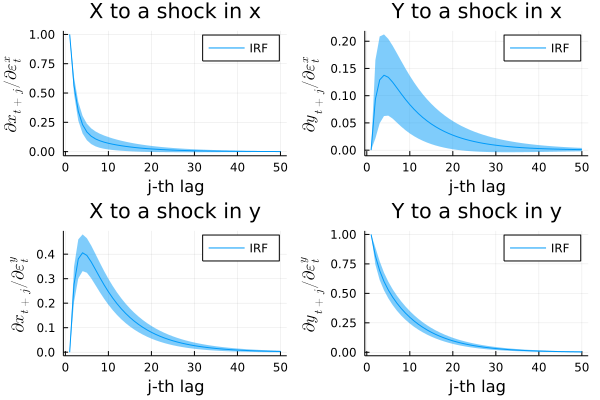

In [71]:
#boot_irf1 = plot(q2_irf_matrix_1[1:50,1], ribbon=(matrix_x1_conf[1:50,1], matrix_x1_conf[1:50,1]), lab="estimate")
#boot_irf2 = plot(q2_irf_matrix_1[1:50,2], ribbon=(matrix_x2_conf[1:50,1], matrix_x2_conf[1:50,1]), lab="estimate")
#boot_irf3 = plot(q2_irf_matrix_2[1:50,1], ribbon=(matrix_y1_conf[1:50,1], matrix_y1_conf[1:50,1]), lab="estimate")
#boot_irf4 = plot(q2_irf_matrix_2[1:50,2], ribbon=(matrix_y2_conf[1:50,1], matrix_y2_conf[1:50,1]), lab="estimate")
boot_irf1 = plot(q2_irf_matrix_1[1:50,1], ribbon=(matrix_x1_conf[1:50,1], matrix_x1_conf[1:50,1]), title = "X to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^x")
boot_irf2 = plot(q2_irf_matrix_1[1:50,2], ribbon=(matrix_x1_conf[1:50,1], matrix_x1_conf[1:50,1]), title = "Y to a shock in x", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^x")
boot_irf3 = plot(q2_irf_matrix_2[1:50,1], ribbon=(matrix_x1_conf[1:50,1], matrix_x1_conf[1:50,1]), title = "X to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial x_{t+j}/\partial\epsilon_{t}^y")
boot_irf4 = plot(q2_irf_matrix_2[1:50,2], ribbon=(matrix_x1_conf[1:50,1], matrix_x1_conf[1:50,1]), title = "Y to a shock in y", label="IRF", xlabel="j-th lag", ylabel=L"\partial y_{t+j}/\partial\epsilon_{t}^y")

plot(boot_irf1, boot_irf2, boot_irf3, boot_irf4, layout = l)

The bootstrap confidence intervals are symmetric. Additionally, they widen and decrease with the dynamic of IRF. This is an expected behaviour as the starting point of any IRF is fixed around 1 or 0 respectively and converges to zero due to the covariance-stationarity of the process.

In [106]:
# Forecast Error Variance Decomposition
#est_coef
P = cholesky(var_cov).L
est_coef*P

2×2 Matrix{Union{Missing, Float64}}:
 0.655145  0.261024
 0.316157  0.772726

In [107]:
orth_irf1 = [ones(500) zeros(500)]
orth_irf2 = [zeros(500) ones(500)]

for t in 2:500
    orth_irf1[t,1:2] = est_coef*P*orth_irf1[t-1,:]
    orth_irf2[t,1:2] = est_coef*P*orth_irf2[t-1,:]
end

In [108]:
orth_irf1, q2_irf_matrix_1

([1.0 0.0; 0.6551447292491088 0.3161567449186517; … ; 13.960699658317406 18.827343859708627; 14.060663447988897 18.962154627630525], [1.0 0.0; 0.5644010237210271 0.09346869444344152; … ; 1.4847777827138364e-25 1.7772590665755336e-25; 1.3281518022180875e-25 1.589779871279006e-25])

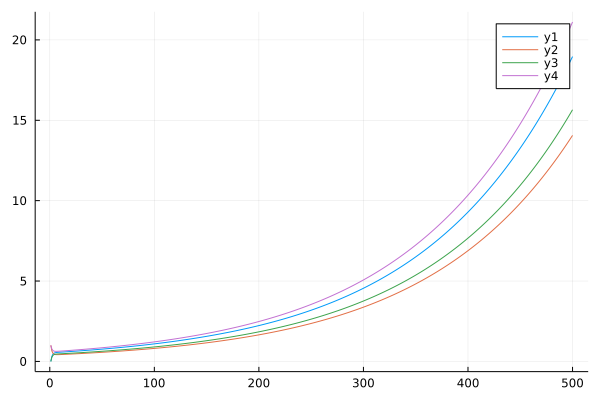

In [109]:
plot([orth_irf1[:,2] orth_irf1[:,1] orth_irf2[:,1] orth_irf2[:,2]])